# Improving Numerical Integration Methods

The solution and estimation of Dynamic Discrete Choice Models (DDCM) is often constrained by computational feasability. For instance, Keane and Wolpin (1997) and subsequent work that estimates DDCM's of post-graduation career dynamics abstract from many important determinants of earnings and mobility dynamics. Examples include the isolation from match heterogeneity, permanent skill shocks, and abscence of multidimensional skill structures.

Keane and Wolpin (1994, 1997) split their occupational classes into white- and blue-collar occupations. Nevertheless, empirical evidence suggests that skill requirements vary substantially within blue- and white-collar occupations. Arguably any aggregation of occupational classes should be able to account for meaningful skill differences. Acemoglu and Autor (2011) suggest four aggregate groups that are explicitly derived from the task content of classified three digit occupations in the US data.[<sup>1</sup>](#fn1)

Adding elements alike enlarges the computational burden of solving a DDCM enormously, and as already Keane and Wolpin (1994) noted, "[...] for problems of the size we would like to consider a [...] simulation strategy is not computationally practicable". A bottleneck in solving and estimating DDCM's is the solution of the expected value function, the so-called $EMax(\cdot)$. Adding new features to the model increases the required number of function evaluations, which are the costly operation in numerical integration. Results from applied mathematics suggest methods that are more efficient and thus enable a performance increase. For the same number of function evaluations (and hence computational cost) quasi-Monte Carlo methods achieve a significantly higher accuracy.

With ``respy`` it is possible to employ quasi-Monte Carlo methods to solve and estimate DDCM's. This notebook contains a tutorial on how to specify the numerical integration option in ``respy``. For expositional purposes we will rely on the Keane and Wolpin (1994) model. The subsequent sections:

- Will explain how to choose a Monte Carlo method in `respy`.
- Will describe how to choose the number of iterations.
- Provide a simulation study: How does the integration method affects the solution of the model?

The following [slides](https://github.com/HumanCapitalAnalysis/student-project-rafael_suchy/blob/master/slides/numerical_integration_ddcm.pdf) provide a gentle introduction into the Keane and Wolpin (1994) model and highlight its main components. Additionally the reason and basic intuition for the usage of Monte Carlo and quasi-Monte Carlo methods are outlined.

In [1]:
%matplotlib inline

import pandas as pd
import respy as rp
import numpy as np
import chaospy as cp
import matplotlib.pyplot as plt

from matplotlib import ticker
from _numerical_integration import *

## Numerical Integration in respy

The current functionality of ``respy`` entails two main methods for the numerical approximation of the $EMax(\cdot)$:

- Monte Carlo Simulation: Chooses points randomly in the domain 
- Quasi Monte Carlo Simulation: Chooses points from one of the two low-discrepancy sequences
  - Sobol
  - Halton
        
A very short introduction about the nature of low-discrepancy sequences is provided in the following [notebook](https://github.com/HumanCapitalAnalysis/student-project-rafael_suchy/blob/master/notebooks/98_low_discrepancy_sequences_application_integration.ipynb).

Now it is finally time to get our hands on the implementation in ``respy``. The main method affected is ``create_base_draws`` within ``shared.py``, which as the name suggests creates a set of draws from the standard normal distribution. The draws are either drawn randomly (Monte Carlo Simulation) or from low-discrepancy sequences (Quasi-Monte Carlo Simulation). Either of the methods is used to calculate the $EMax(\cdot)$ in the solution *and* the choice probabilities in the maximum likelihood estimation.

## How to choose the Monte Carlo Method in respy

As mentioned, we will use the Keane and Wolpin (1994) model within this tutorial. First, we retrieve the parametrization. For details, you are welcomed to consult the previous tutorials of this readme. 

In [2]:
params, options = rp.get_example_model("kw_94_one", with_data=False)

The set of *options* helps to define the underlying model and characterizes the solution methods as well as some functional forms. Inspecting the content we recognize the relevant options `solution_draws` and `monte_carlo_sequence`. 

In [3]:
options

{'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 500,
 'interpolation_points': -1,
 'n_periods': 40,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 1,
 'monte_carlo_sequence': 'random',
 'core_state_space_filters': ["period > 0 and exp_{i} == period and lagged_choice_1 != '{i}'",
  "period > 0 and exp_a + exp_b + exp_edu == period and lagged_choice_1 == '{j}'",
  "period > 0 and lagged_choice_1 == 'edu' and exp_edu == 0",
  "lagged_choice_1 == '{k}' and exp_{k} == 0",
  "period == 0 and lagged_choice_1 == '{k}'"],
 'covariates': {'constant': '1',
  'exp_a_square': 'exp_a ** 2',
  'exp_b_square': 'exp_b ** 2',
  'at_least_twelve_exp_edu': 'exp_edu >= 12',
  'not_edu_last_period': "lagged_choice_1 != 'edu'",
  'edu_ten': 'exp_edu == 10'}}

The option `solution_draws` specifies how many points (iteration) are simulated (performed) in order to solve the model. Ceteris paribus, choosing more points leads to a higher precision but also to higher computational costs. The option `monte_carlo_sequence` determines the method.[<sup>2</sup>](#fn2) As we will see, the implementation of quasi-Monte Carlo methods enables to break the trade-off: It is possible to increase the accuracy for a given set of points, switching from Monte Carlo methods to quasi-Monte Carlo methods.

It is possible to choose `monte_carlo_sequence` from the set of $\{$"random", "halton", "sobol" $\}$. In the following we will use the Sobol sequence with 200 draws to solve the model (`rp.solve`), by changing the option parameters as follows.

In [4]:
options["monte_carlo_sequence"], options["solution_draws"] = ["sobol", 200]
state_space = rp.solve(params, options)

To verify, we can shortly check whether the options were changed correctly.

In [5]:
options["monte_carlo_sequence"], options["solution_draws"]

('sobol', 200)

Up to this point, all necessary information to change the integration option is mentioned. The eager reader can start to experiment with its own model (or a different Keane and Wolpin specification). In the next section we will provide an example and simulate the Keane and Wolpin (1994) model with different options. We will elaborate on how the employed Monte Carlo methods affects the model.

---
## Simulation study: How does the integration method affects the solution of the model?

We will simulate the model with either of the methods: "random", "halton", "sobol" and vary the amount of points from `POINTS_MIN` to `POINTS_MAX` by increments of (`POINTS_MAX` -  `POINTS_MIN`)/`NUM_EVALS` that are used in the solution of the model. A reference value is calculated by using a very large amount of points ``POINTS_TRUTH``. Note, solving the whole model with ``POINTS_TRUTH`` repeatedly would not be possible at all. 

In [7]:
# For a real application you might change the points as commented
POINTS_TRUTH = 1_000  # 1_000_000

POINTS_MIN = 2  # 100  
POINTS_MAX = 4  # 10_000
NUM_EVALS = 10  # 100      
POINTS_GRID = np.logspace(
    POINTS_MIN, 
    POINTS_MAX, 
    NUM_EVALS, 
    dtype = int
)

METHODS = ["random", "halton", "sobol"]

First, we will compute a reference value for the $EMax(\cdot)$ values by using a large amount of points with the "sobol"-sequence. We extract the "true" $EMax(\cdot)$ values into the object `emax_true`.

<center>
    <b>Caution:</b> Execution may take some time.
</center> 

In [8]:
options["monte_carlo_sequence"], options["solution_draws"] = ["sobol", POINTS_TRUTH]

state_space = rp.solve(params, options)
emax_true = state_space.emax_value_functions

Second, we will loop over the methods and the number of points to calculate the $EMax(\cdot)$ for each specification of the model. 

<center>
    <b>Caution:</b> Execution may take even some more time. <br>
    Alternatively, you can load the results from the pre-simulated pickle-file.
</center> 

In [9]:
df_emax_values = pd.DataFrame(index=POINTS_GRID, columns=METHODS)

for method in METHODS:
    options["monte_carlo_sequence"] = method
    print("Current Iteration:", method.capitalize(), ".")
    for points in POINTS_GRID:
        options["solution_draws"] = points
        state_space = rp.solve(params, options)
        df_emax_values.loc[points][method] = state_space.emax_value_functions

Current Iteration: Random .
Current Iteration: Halton .
Current Iteration: Sobol .


To prevent doing the calculation over and over again, we will save our results in pickle files. 

In [11]:
indices =  range(
    df_emax_values.loc[POINTS_GRID[1], 
    METHODS[0]].shape[0]
)

int_points = POINTS_GRID
index = list()
for point in int_points:
    for idx in indices:
        index.append((point, idx))

<center>
    <b>Caution:</b> Execution may take even some more time. <br>
    Alternatively, you can load the results from the pre-simulated pickle-file.
</center> 

In [12]:
index = pd.MultiIndex.from_tuples(
    index, 
    names=('integration_points', 'state_index')
)

df_emax_values_store = \
pd.DataFrame(
        columns=[*METHODS], index=index)

for points in df_emax_values.index:
    for method in METHODS:
        df_emax_values_store[method].loc[points, :] = df_emax_values.loc[points, method]

For exposition of the convergence results, we will look at one particular approximation. For example at iteration number 14.

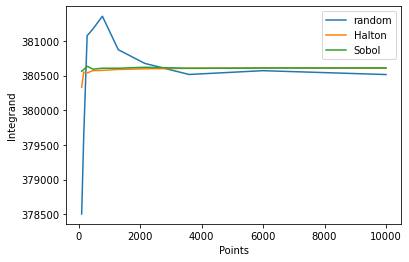

In [13]:
which_integrand = 14
get_single_integrand(df_emax_values_store, which_integrand, 1, METHODS)

We see that the quasi-Monte Carlo methods are stable after around 500 iterations (points) whereas the random sequence oscillates even for a large number of points. To get a more elaborate picture, we can zoom-in into the figure and inspect the behavior for a low amount of points. It gets evident that already after 200 points the `halton` and `sobol` options yield stable results.

A more theoterically founded method (vs. pure eyeballing) to evaluate the performance of our numerical integration is the calculation of the Root Mean Squared Error (RMSE). For this reason we first define some evaluation criteria.

In [15]:
def rmse(x1, x2, scaling_param = 1, axis = 0):
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    scaling_param = np.asanyarray(scaling_param)
    return np.sqrt(
        np.mean(((x1 - x2) ** 2)/scaling_param,
        axis = axis)
        )

In [16]:
df_rmse_comparison = pd.DataFrame(index = POINTS_GRID, columns = METHODS)
df_rel_rmse_comparison = pd.DataFrame(index = POINTS_GRID, columns = METHODS)

for points in POINTS_GRID:
    for method in METHODS:
        df_rmse_comparison.loc[points][method] = rmse(df_emax_values.loc[points][method], emax_true, 1, 0)
        df_rel_rmse_comparison.loc[points][method] = rmse(df_emax_values.loc[points][method], emax_true, df_emax_values.loc[points][method], 0)

## How to choose the number of iterations?

Already in 1975 Hoaglin and Andrews set up recommendations how to report results and procedures when performing simulation studies. Hauck and Anderson (1984) surveyed 1,198 papers in five major statistical journals where 216 provided results that were based on simulation. Only 9% of papers that used a simulation study justified the choice of the number of iterations. This is contrary to the recommendations by Hoaglin and Andrews.[<sup>3</sup>](#fn3) 

Harwell (2018) provide an update of the survey. The authors survey studies in six statistics journals between 1985 to 2012 and report that the use of simulation studies had doubled since 1984. An improvement of reporting standards was not found: Less than 18 of 371 simulation studies used an experimental design that could be identified. Additionally, 99.9% of the studies relied solely on a visual analysis of the results. In this section we will provide some ideas how to substantiate the number of iterations within (quasi-)Monte Carlo simulations.

### Number of iterations for Monte Carlo Analysis 

The variance expression of Monte Carlo methods can guide the calculation of the number of iterations. Suppose we simulate $N$ samples (iterations). The variance is approximately given by
$$
    \dfrac{\sigma^2(f)}{N}.
$$

A-priori, the value of $\sigma^2(f)$ is unknown but can be estimated. Similar to our calculation of the `emax_true` we can simulate a sample with `POINTS_TRUTH` number of iterations. Out of this sample we can estimate $\sigma^2(f)$. Specifying a desired precision $\rho$ we can immediately calculate the necessary number of iterations[<sup>4</sup>](#fn4)  as 

$$
    \sqrt{M} \approx \dfrac{\sigma}{\rho}.
$$

A different, less scientific approach acknowledges the diversity of problems than can be tackled with Monte Carlo simulations. A fixed number of iterations may serve as a first guideline and substantiated reasoning that is followed by additional refinement. Quantifying extremely small probabilities needs a different amount of iterations than quantifying a mean. Bukaçi et al. (2016) propose a method that is based solely on convergence plots. For the graphical evaluation it is necessary to calculate the value of interest (for example the value of the $EMax(\cdot)$) repeatedly using different number of iterations. Following Bukaçi et al. (2016) the number of iterations at which the Monte Carlo estimate becomes stable can be used in the simulation study.

### Number of iterations for quasi-Monte Carlo Analysis 

To reiterate, with the same computational effort (same number of function evaluations) the quasi-Monte Carlo methods achieve a higher accuracy than the MC method. Hence, having a number of iterations for the Monte Carlo method, we certainly know that employing a quasi-Monte Carlo procedure will perform better. Due to the completely deterministic nature of quasi-Monte Carlo methods (integration) we obtain deterministic, and hence guaranteed error bounds. Theoretically, it is always possible to determine an integration rule that yields a prescribed level of precision. 

Formally we can use the Koksma-Hlawka inequality to determine an error bound resulting from quasi-Monte Carlo methods.[<sup>5</sup>](#fn5) If the random variable (integrand) $f$ has bounded variance $\mathbb{V}(f)$ on $\bar{I}^d$, then for any sample of nodes $x_1, \dots, x_N \in \bar{I}^d$ we have 

$$
    \left| \dfrac{1}{N} \sum_{i=1}^N f(x_i) - \int_{\bar{I}^d} f(u) \mathrm{d}u ~\right| \leq \mathbb{V}(f) D_N^*(x_1, \dots, x_N),
$$

where $D_N^*$ denotes the star discrepancy[<sup>6</sup>](#fn6) of the nodes.

If we are able to calculate all expressions in the Koksma-Hlawka inequality the required number of iterations for a pre-specified precisions follows immediately. The world could be so easy if the derivation of the Koksma-Hlawka inequality would not point towards a drawback: it does not apply to functions that have (simple) discontinuities. To circumvent this issue Brandolini et al. (2013) derive a Koksma-Hlawka-type inequality which applies to piecewise smooth functions. Nevertheless, oftentimes it is not feasible to calculate the expressions involved in the Koksma-Hlawka inequality (at least not without difficulties). 

However, the Koksma-Hlawka inequality offers an additional insight: point sets with a small discrepancy guarantee small errors when using quasi-Monte Carlo methods for numerial integration. Number generators based on integer arithmetic module two, like the Sobol-sequence, provide additional equidistribution properties *whenever* the number of iterations $N$ is a power of two, $N = 2^n- 1$. Specifically, our [notebook](https://github.com/HumanCapitalAnalysis/student-project-rafael_suchy/blob/master/notebooks/98_low_discrepancy_sequences_application_integration.ipynb) demonstrates that those sequences are only equidistant, and hence have the minimal star discrepancy, if we have $N = 2^n – 1$ points.[<sup>7</sup>](#fn7) Consequently, employing iterations that satisfy this condition we can improve our procedure without incurring additional costs. This fact came to our mind when elaborating on the concept of Frolov points (Kacwin et al. (2018)).

### Convergence Plots

Another very useful assessment criterion are convergence plots (on log-log scale). 

In [18]:
indices =  range(df_emax_values.loc[POINTS_GRID[1], 'sobol'].shape[0])
int_points = POINTS_GRID

index_rmse = list()
for label in ['absolute', 'relative']:
    for point in int_points:
        index_rmse.append((label, point))
index_rmse = pd.MultiIndex.from_tuples(index_rmse, names=('measure', 'integration_points'))
df_rmse_total = \
pd.DataFrame(
        columns=METHODS, index=index_rmse)

df_rmse_total.loc['relative', :] = df_rel_rmse_comparison.values
df_rmse_total.loc['absolute', :] = df_rmse_comparison.values

To compare our achieved convergence rates with theoretical results, we define reference comparison rates. For the choice of the functional form, please refer to "Appendix: Notes on (quasi-)Monte Carlo approximation".

In [19]:
rates_comparison = [
    [(0.1 * np.log(points)**4)/(points) for points in POINTS_GRID-1],
    [(0.05 * np.log(points)**4)/(points)**(1/2) for points in POINTS_GRID-1],
    [(6 * np.log(points)**4)/(points)**(3/2) for points in POINTS_GRID-1]
    ]

An inspection of the second figure directly reveals the cost of improving our precision. If we want to decrease our relative RMSE to 10$^{-2}$ then we need to increase our points from 10$^2$ to 10$^3$. Furthermore we see that the options `sobol` and `halton` perform much better than employing a random sequence. In fact for our problem quasi-Monte Carlo methods reach nearly theoretically predicted convergence rates.

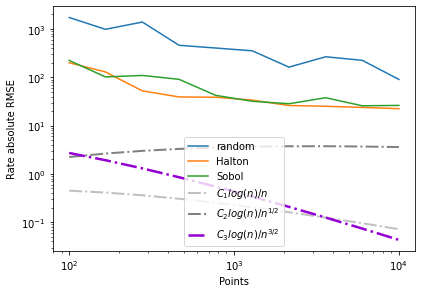

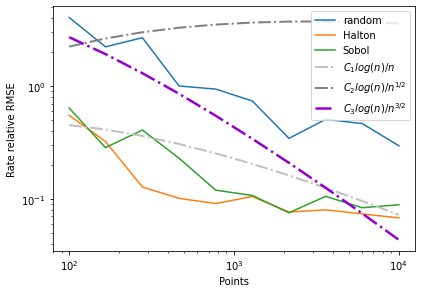

In [20]:
get_rmse_rate(df_rmse_total, rates_comparison, METHODS)

## Evaluation of Economic Relevance

Up to now we have shown that the choice of `monte_carlo_sequence` matters for the RMSE, the precision of our value function calculation, and the number of involved iterations. The next natural question is to ask whether computational decisions translate into economically relevant differences. For example, does the policy-conclusion of a schooling subsidy changes when we employ a different integration method leaving all else equal?

We tackle this question within the Keane and Wolpin (1994) model. First, we fetch the model and load the accompanying data set. We simulate 4000 agents and iterate over the options `monte_carlo_sequence` while comparing the status quo with a tuition subsidy of 500 monetary units. If the reader is interested to simulate other tuition subsidies, the possible sets are included as comments.

In [21]:
params, options, _ = rp.get_example_model("kw_94_one") 

options["simulation_agents"] = 4_000  # Get the amount of agents we are simulating
options["solution_draws"] = 400  # Manually set the number of points to be drawn 

# Initialize simulation
simulate = rp.get_simulate_func(params, options)

In [22]:
# Full set of models: models = np.repeat(["one", "two", "three"], 3)
MODELS = np.repeat(["one"], 2)
# Full set of tuition subsidies: [0, 500, 0, 1_000, 0, 2_000]
TUITION_SUBSIDIES = [0, 500]

In [23]:
index_row = pd.MultiIndex.from_product(
    [METHODS, POINTS_GRID], 
    names = ["Method", "Points"]
)  

df_avg_yos = pd.DataFrame(
    index = index_row, 
    columns = TUITION_SUBSIDIES
)  # Contains average years of schooling per individual

df_diff_avg_yos = pd.DataFrame(
    index = index_row, 
    columns = TUITION_SUBSIDIES
)  # Contains difference to "true" years of schooling per individual

<center>
    <b>Caution:</b> Execution may take even some more time. <br>
    Alternatively, you can load the results from the pre-simulated pickle-file.
</center> 

In [24]:
subsidy_emax_truth = dict() 
for s in TUITION_SUBSIDIES:
    
    print("Runtime check tuition subsidy:", s, u'\u2713')
    params.loc[("nonpec_edu", "at_least_twelve_exp_edu"), "value"] += s  # Increase the subsidy parameter
    options["monte_carlo_sequence"], options["solution_draws"] = ["random", POINTS_TRUTH]   # Set options for evaluation of "truth"
    
    simulate = rp.get_simulate_func(params, options)  # Build the simulation function
    subsidy_emax_truth[s] = simulate(params).groupby("Identifier")['Experience_Edu'].max().mean()
    for method in METHODS:
        options["monte_carlo_sequence"] = method
        print("Runtime check method:", method, u'\u2713')
        for points in POINTS_GRID:
                options["solution_draws"] = points
                simulate = rp.get_simulate_func(params, options)
                df_avg_yos[s].loc[method, points] = simulate(params).groupby("Identifier")['Experience_Edu'].max().mean()
                df_diff_avg_yos[s].loc[method, points] = df_avg_yos[s].loc[method, points] - subsidy_emax_truth[s]
    params.loc[("nonpec_edu", "at_least_twelve_exp_edu"), "value"] -= s  # Decrease the subsidy to initial value

Runtime check tuition subsidy: 0 ✓
Runtime check method: random ✓
Runtime check method: halton ✓
Runtime check method: sobol ✓
Runtime check tuition subsidy: 500 ✓
Runtime check method: random ✓
Runtime check method: halton ✓
Runtime check method: sobol ✓


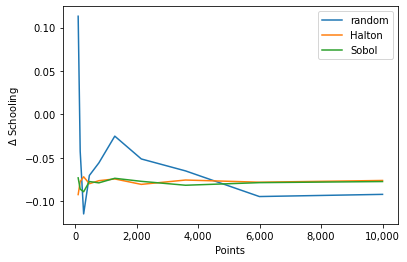

In [25]:
get_policy_prediction(df_diff_avg_yos, *TUITION_SUBSIDIES, METHODS)

This figure reveals that the change in average years of schooling as a result of the 500 MU tuition subsidy is sensitive to the employed methods and choice of iterations. While `sobol` and `halton` provide reliable and stable results after 200 iterations this does not hold true for the `random` option. Using between 10 and 1000 iterations 8 $\%$ of the policy effect are driven by the choice of the Monte Carlo method. 

## Remarks

<span id="fn1"><sup>1</sup>
    Over the last few decades the empirical literature established a relatively weak economic performance of occupations that require workers to solve routine cognitive or routine manual tasks. Dimensions of occupational skill requirements, skill prices, and employment shares evolved substantially in the last years. As the authors suggest, distinction between   
    $~~~~~$ a) abstract, non-routine tasks (e.g. managerial)   
    $~~~~~$ b) routine cognitive tasks (e.g. adminstrative and sales),   
    $~~~~~$ c) routine manual tasks (e.g. production),    
    $~~~~~$ d) non-routine manual tasks (e.g. service occupations).   
may be more appropriate 
</span>

<span id="fn2"><sup>2</sup>
    Please do not get confused. Although the option name is called `monte_carlo_sequence` it does indeed inlcude the Quasi-Monte Carlo methods. The naming convenation was chosen this way, because in ``respy`` we regard Monte Carlo methods as the aggregate group. 
</span>

<span id="fn3"><sup>3</sup>
    A review of papers within Economics would probably indicate a similar state.   
</span>


<span id="fn4"><sup>4</sup>
    See [Niederreiter (1992)](https://epubs.siam.org/doi/book/10.1137/1.9781611970081) for a thorough treatment including methods for variance reduction.
</span>

<span id="fn5"><sup>5</sup>
    A derivation can be found at pp.19f in [Niederreiter (1992)](https://epubs.siam.org/doi/book/10.1137/1.9781611970081).
</span>


<span id="fn6"><sup>6</sup>
    See [Niederreiter (1992)](https://epubs.siam.org/doi/book/10.1137/1.9781611970081) p.14 for the definition.
</span>

<span id="fn7"><sup>7</sup>
    If 0 is explicitly included in the construction of the sequence then the term “$-1$” can be dropped.
</span>

## Appendix: Notes on (quasi-)Monte Carlo approximation

This section will serve as a short introduction into the idea and notation of (quasi-)Monte Carlo integration, especially why the function $f$ can be treated as integrand and simultaneously as random variable. To discuss an approximate calculation of the integral $\int_{\mathbb{D}} f(u) \mathrm{d}u$ we will assume that the integration domain $\mathbb{D} \subseteq \mathbb{R}^d$ satisfies $0 < \lambda_d(\mathbb{D}) < \infty$. We denote the d-dimensional Lebesgue measure with $\lambda_d$. 

By defining the probability meaure $\mathrm{d}\mu = \dfrac{\mathrm{du}}{\lambda_d(\mathbb{D})}$ we turn the domain $\mathbb{D}$ into a probability space. In this notation we can rewrite the integral as 

$$ 
    \int_{\mathbb{D}} f(u) \mathrm{d}u = \lambda_d(\mathbb{D}) f \mathrm{d}\mu = \lambda_d(\mathbb{D}) \mathbb{E}[f], 
$$

where $\mathbb{E}[f]$ denotes the expected value of the random variable $f$.  The Monte Carlo estimate for the expected value $\mathbb{E}[f]$ is obtained by taking $N$ independent $\lambda$-distributed random samples $s_1, \dots, s_N$ from the domain $A$ of the random variable $f$ and let 

$$ 
    \mathbb{E}[f] \approx \dfrac{1}{N} \sum_{i=1}^N f(s_i).
$$

A derivation (as provided in Niederreiter) shows that we can formalize the Monte Carlo estimate as follows

$$ 
\int_{\mathbb{D}} f(u) \mathrm{d}u \approx \dfrac{1}{N} \sum_{i=1}^N f(y_i),
$$

The nodes $y_i, \dots, y_N$ are $N$ independent random samples from a uniform distribution on $\bar{I}^d$, where $\bar{I}^d$ denotes the closed d-dimensional unit cube. We have a probabilistic error bound of $O(N^{-1/2})$.

The quasi-Monte Carlo approximation looks formally like the MC estimate but is used with deterministic nodes $x_1, \dots, x_N  \in \bar{I}^d$. We take $\mathbb{D}$ as a subset of $\bar{I}^d$ and choose deterministic points $x_1, \dots, x_N \in \mathbb{D}$.  The QMC approximation is given by

$$
\int_\mathbb{D} f(u) \mathrm{d}u \approx \dfrac{1}{N} \sum_{i=1}^N f(x_i).
$$

We get a deterministic error bound of $O(N^{-1}(log(N))^{d-1})$, where $d$ denotes the number of (effective) dimensions as 

### Theoretical error bounds as benchmark

The theoretical results on convergence (error bounds) are particularly useful when we want to determine whether our integration problem is suited for (quasi-)Monte Carlo methods. Or vice versa: whether (quasi-)Monte Carlo methods are appropriate to solve our integration problem. As our convergence plots indicate, the rate of the employed quasi-Monte Carlo methods `"halton"` and `"sobol"` nearly attain their theoretical counterpart. Hence, we can conlude that our integration problem is indeed suited to be solved by quasi-Monte Carlo methods.

## References

> Acemoglu, D. and D. Autor (2011). [Skills, Tasks and Technologies: Implications for Employment and Earnings](https://economics.mit.edu/files/7006). *Handbook of Labor Economics*, Chapter 12, Vol. 4b.

> Bellman, R. E. (1957). ["Dynamic Programming"](https://press.princeton.edu/titles/9234.html). Princeton University Press, Princeton, NJ.


> Bukaçi, E. et al. (2016). [Number of iterations needed in Monte Carlo Simulation using reliability analysis for tunnel supports](https://www.ijera.com/papers/Vol6_issue6/Part%20-%203/J0606036064.pdf). *International Journal of Engineering Research and Applications*, 6(6): pp.60-64.

> Brandolini, L., Colzani, L., Gigante, G., and Travaglini, G. (2013). [On the Koksma–Hlawka inequality](https://www.sciencedirect.com/science/article/pii/S0885064X12000854#b000005). *Journal of Complexity*, 29(2): 158-172.

> Caflisch, R.E. (1998). [Monte Carlo and quasi-Monte Carlo methods](http://dsec.pku.edu.cn/~tieli/notes/numer_anal/MCQMC_Caflisch.pdf). *Acta Numerica*, 1-49.

> Caflisch, R.E., Morokoff, W., and Owen, A. (1997). [Valuation of Mortgage backed securities using Brownian bridges to reduce effective dimension](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.36.3160) *Journal of Computational Finance*, 1: 27-46.

> Davis, P. J. and Rabinowitz, P. (1984). ["Methods of Numerical Integration"](https://store.doverpublications.com/0486453391.html). Dover Publications, Mineola, NY.

> Gerstner, T. and Griebel, M. (1998). ["Numerical Integration using Sparse Grids"](https://rdcu.be/bPFpc). *Numerical Algorithms* 18: 209–232.

> Halton, J. (1964). ["Algorithm 247: Radical-inverse Quasi-Random Point Sequence"](https://dl.acm.org/citation.cfm?id=365104). *Communications of the ACM,* 7: 701-701.

> Hauck, W.H. and Anderson, S. (1984). [A Survey Regarding the Reporting of Simulation Studies](https://amstat.tandfonline.com/doi/abs/10.1080/00031305.1984.10483206#.XjP298hKiUk). *The American Statistician*, 38(3): 214–216.

> Hoaglin, D.C. and Andrews, D.F. (1975). [The Reporting of Computation-Based Results in Statistics](https://www.tandfonline.com/doi/citedby/10.1080/00031305.1975.10477393?scroll=top&needAccess=true). *The American Statistician*, 29(3): 122–126.  

> Harwell, M., Nidhi, K., and Peralta-Torres, Y. (2018). [A Survey of Reporting Practices of Computer Simulation Studies in Statistical Research](https://www.tandfonline.com/doi/full/10.1080/00031305.2017.1342692?scroll=top&needAccess=true). *The American Statistician*, 72(4): 321-327.

> Kacwin, C., Oettershagen, J., Ullrich, M., and Ullrich, T. (2018). [Numerical performance of optimized Frolov lattices in tensor product reproducing kernel Sobolev spaces.](https://ins.uni-bonn.de/media/public/content-frolov-frolov/FrolovNumerics.pdf?pk=6) ArXiv e-prints, 2018.

> Keane, M.P. and Wolpin, K.I. (1994). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://www.jstor.org/stable/2109768?seq=1). *The Review of Economics and Statistics*, 76(4): 648-672.

> Keane, M.P. and Wolpin, K.I. (1997). [The Career Decisions of Young Men](https://doi.org/10.1086/262080). *Journal of Political Economy*, 105(3): 473-522.

> Lemieux, C. (2009). ["Monte Carlo and Quasi-Monte Carlo Sampling"](https://www.springer.com/gp/book/9780387781648). Springer, Boston, MA.

> L’Ecuyer, P. (2017). ["Randomized Quasi-Monte Carlo: An Introduction for Practitioners"](https://hal.inria.fr/hal-01561550/document). 12th International Conference on Monte Carlo and Quasi-Monte Carlo Methods in Scientific Computing (MCQMC 2016), August 2016, Stanford, CA.

> L’Ecuyer, P. and Lemieux, C. (2005). ["Recent Advances in Randomized Quasi-Monte Carlo Methods"](https://link.springer.com/chapter/10.1007%2F0-306-48102-2_20).   In: Dror M., L’Ecuyer P., Szidarovszky F. (eds) Modeling Uncertainty. *International Series in Operations Research & Management Science,* Vol. 46, Springer, Boston, MA.

> Niederreiter, H. (1992). [Random Number Generation and Quasi-Monte Carlo Methods](https://epubs.siam.org/doi/book/10.1137/1.9781611970081). *CBMS-NSF Regional Conference Series in Applied Mathematics*.

> Puterman, M. L. (1994). ["Markov Decision Processes: Discrete Stochastic Dynamic Programming (1st ed.)"](https://dl.acm.org/citation.cfm?id=528623). John Wiley & Sons, Inc., New York, NY, USA.

> Skrainka, B. S. and K. L. Judd. (2011). ["High Performance Quadrature Rules: How Numerical Integration Affects a Popular Model of Product Differentiation"](https://www.ucl.ac.uk/~uctpbss/EconSite/Research_files/HighPerformanceQuad.pdf). Unpublished. 

> Sobol, I. M. (1967). ["Distribution of Points in a Cube and Approximate Evaluation of Integrals"](http://mi.mathnet.ru/eng/zvmmf7334). *Zh. Vych. Mat. Mat. Fiz.,* 7: 784–802 (in Russian); *U.S.S.R Comput. Maths. Math. Phys.7*: 86–112.

> Wang, X. and Fang, K.T. (2003). [The effective dimension and quasi-Monte Carlo integration](https://www.sciencedirect.com/science/article/pii/S0885064X03000037#BIB3). *Journal of Complexity*, 19(2): 101-124.

> Wolpin, K. I. (2013). [The Limits of Inference without Theory](https://mitpress.mit.edu/books/limits-inference-without-theory). MIT Press, Cambridge, MA.